# Tutorial: CTCF motif annotation

In this example we demonstrate how one could use _rnalib_ and _bioframe_ together for maximum benefit.

This tutorial was inspired by the [bioframe CTCF tutorial](https://bioframe.readthedocs.io/en/latest/tutorials/tutorial_assign_motifs_to_peaks.html) but implements a different scenario.
Briefly, we use _rnalib_ to instantiate a human Transcriptome (canonical protein-coding transcripts on chromosome 2 only), download an CTCF motif dataset with _bioframe_ and annotate all transcripts with those motifs. We then report all genes/transcripts with at least one overlapping CTCF motif. We demonstrate two annotation scenarios and compare their runtimes.
We also show how to add CTCF sites as custom features to the transcriptome and how to access their sequences that are sliced automaticallz from their enveloping parent features.

First, we load the required libraries.

## Requirements
Before executing this notebook, you need to install all required *rnalib* requirements as well as optional libraries needed by this notebook.
It is recommended to do this in a [Python virtual environment](https://rnalib.readthedocs.io/en/latest/readme.html#installation).

This notebook as well as *rnalib*'s testing suite use various **test resources** (genomics data files and indexing structures) that can either be downloaded from the Github repository or 
created by running the *rnalib* `rnalib_create_testdata` script. Please refer to [the rnalib documentation](https://rnalib.readthedocs.io/en/latest/readme.html#test-data) for detailed instructions.
There are two separate test resource sets:

* *test_resources*: small test datasets that are used by *rnalib*'s test suite
* *large_test_resources*: larger test files that are needed to demonstrate *rnalib* under realistic conditions. 

*Rnalib* knows about the location of the test data via the package-global __RNALIB_TESTDATA__ variable. This variable can either be set via the "RNALIB_TESTDATA" environment variable or by 'monkeypatching' (rna.__RNALIB_TESTDATA__ = ...) as shown below. Once this is done, test data resources can be accessed via `rna.get_resource(<resource_id>)`. *Rnalib* will recreate these resources only if they are not found in the configured output folder.

In [2]:
import os, pathlib, platform
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ssl
import bioframe
from collections import Counter

# load rnalib
import rnalib as rna
from rnalib import gi, GI, SEP, display_textarea
display(f"Running rnalib {rna.__version__} on python {platform.python_version()}")

# ensure test data
rna.__RNALIB_TESTDATA__ = "rnalib_testdata/" # monkeypatch test data dir
rna.testdata.create_testdata(rna.__RNALIB_TESTDATA__, rna.testdata.test_resources) # requires additional tools installed
display(f"Testdata in {rna.__RNALIB_TESTDATA__}")
display_textarea('\n'.join(rna.dir_tree(pathlib.Path(rna.__RNALIB_TESTDATA__))))

'Running rnalib 0.0.3 on python 3.12.1'

Creating testdata:   0%|          | 0/40 [00:00<?, ?it/s]

INFO:root:========= All done with 0 errors  ==========


'Testdata in rnalib_testdata/'

## Load CTCF sites
First, we use bioframe to read a set of CTCF binding sites from JASPAR and filter for chromosome 2 and 
minimum P-value.

Please note that this cell might fail with a TimeoutError if the JASPAR data is not accessible.

In [3]:
# see https://genome.ucsc.edu/cgi-bin/hgTrackUi?db=Grch38&g=jaspar
jaspar_uri='http://expdata.cmmt.ubc.ca/JASPAR/downloads/UCSC_tracks/2022/hg38/MA0139.1.tsv.gz'
ssl._create_default_https_context = ssl._create_unverified_context # to avoid invalid certificate problems
ctcf_sites = bioframe.read_table(jaspar_uri, schema='jaspar').query("chrom=='chr20' & pval>500")

## Annotate transcriptome with CTCF sites

Now, we annotate transcripts with JASPAR motifs. We demonstrate two different approaches:

- approach1
    - we instantiate a filtered *rnalib* transcriptome (chr2 only)
    - we then annotate with the JASPAR motifs loaded via *bioframe*
    - for annotation we use a (very flexible) custom callback method
    - finally, we build a *pandas* dataframe with results containing one row per tx
- approach2
    - we read the GFF with *bioframe* and correct the start coordinate as *bioframe* expects 0-based coordinates
    - we overlap tx and CTCF sites with the *bioframe* `overlap()` method (NOTE that we cannot use the inner join as it would change the order of the CTCF sites)
    - we create a results dataframe while filtering for the respective transcripts. This is done base on GFF attributes parsed from the 'attributes' column.

Building transcriptome (1 chromosomes)
:   0%|          | 0/1 [00:00<?, ?it/s]

Build interval trees:   0%|          | 0/546 [00:00<?, ?it/s]

'Annotating transcriptome'

  0%|          | 0/1 [00:00<?, ?it/s]

,gene,tid,location,ctcf_locations,ctcf_scores
0,DEFB132,ENST00000382376.4,chr20:257724-261096 (+),chr20:259132-259150 (+),867
1,C20orf96,ENST00000360321.7,chr20:270863-290750 (-),chr20:279437-279455 (-),871
2,SOX12,ENST00000342665.5,chr20:325552-330224 (+),chr20:326979-326997 (-),878
3,NRSN2,ENST00000382285.7,chr20:347111-354862 (+),chr20:354638-354656 (+),892
4,TBC1D20,ENST00000354200.5,chr20:435480-462533 (-),chr20:442224-442242 (+),874


,gene,tid,location,ctcf_locations,ctcf_scores
0,DEFB132,ENST00000382376.4,chr20:257724-261096 (+),chr20:259132-259150 (+),867
1,C20orf96,ENST00000360321.7,chr20:270863-290750 (-),chr20:279437-279455 (-),871
2,SOX12,ENST00000342665.5,chr20:325552-330224 (+),chr20:326979-326997 (-),878
3,NRSN2,ENST00000382285.7,chr20:347111-354862 (+),chr20:354638-354656 (+),892
4,TBC1D20,ENST00000354200.5,chr20:435480-462533 (-),chr20:442224-442242 (+),874


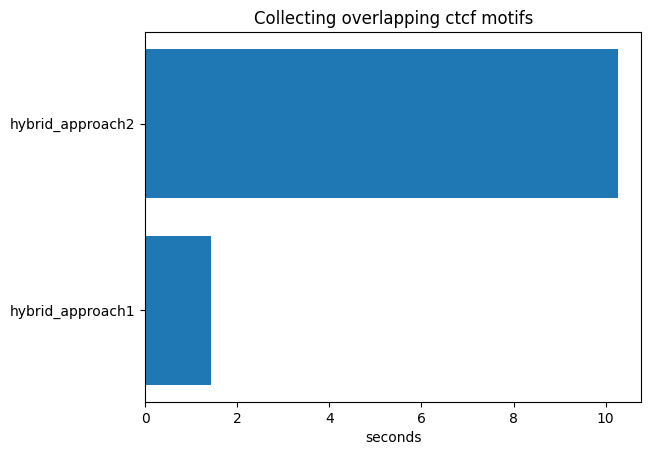

In [4]:
# gencode annotation GFF
times, results=Counter(),Counter()
with rna.Timer(times, 'hybrid_approach1') as timer:
    # Build subset of human transcriptome (canonical protein coding genes on chrom 2)
    t=rna.Transcriptome(
        annotation_gff=rna.get_resource("full_gencode_gff"),
        annotation_flavour='gencode',
        genome_fa = rna.get_resource("grch38_chr20"), # GRCh38 chr20 reference sequence
        feature_filter = rna.TranscriptFilter().include_tags('Ensembl_canonical', include_missing=False).\
            include_gene_types('protein_coding', include_missing=False).include_chromosomes('chr20'),
        load_sequence_data=False
    )
    # custom annotation method
    def anno_ctcf(item, label='ctcf_scores'):
        """ 
            Callback method for annotating transcripts.

            loc: genomic interval of the feature that is annotated
            anno: the transcriptome anno dict for this feature (so you can also access any other already existing annotations for this feature)
            dfrows: list of (loc, row) tuples containing all overlapping locations (loc) and the respective dataframe rows

            This method adds 'ctcf' annotations comprising of a list of (location, score) tuples that are overlapping the annotated transcript
        """
        loc, (anno, dfrows) = item
        if label not in anno:
            anno[label]=[]
        for sloc,dfrow in dfrows:
            anno[label].append((sloc,dfrow.score)) # add ctcf motif annotations
    # anotate all transcripts using the above defined anno_ctcf method
    display("Annotating transcriptome")     
    t.annotate(anno_its=rna.it(ctcf_sites, style='bioframe'), 
               fun_anno=anno_ctcf, 
               feature_types=['transcript'])
    # build dataframe of transcripts with at least one overlapping CTCF peak
    results[timer.name]= pd.DataFrame([(tx.parent.gene_name, 
                                        tx.feature_id,
                                        str(tx.location),
                                        ','.join([str(l) for l,_ in tx.ctcf_scores]),
                                        ','.join([str(s) for _,s in tx.ctcf_scores])) for tx in t.transcript.values() if len(tx.ctcf_scores)>0], 
                                      columns=['gene','tid','location','ctcf_locations','ctcf_scores'])

    
with rna.Timer(times, 'hybrid_approach2') as timer:
    """ Here, we read the gencode annotation data via bioframe and correct the start coordinates as required.
        We then overlap with the ctcf sites and iterate over the resulting dataframe, parse the GFF attributes and
        filter for canonical, protein-coding genes. Finally, we build the result pandas dataframe.
    """
    tx = bioframe.read_table(rna.get_resource("full_gencode_gff"), schema='gff', comment='#').query("chrom=='chr20' & feature=='transcript'")
    tx['start']=tx['start']-1 # we need to correct start coordinates as bioframe coordinates are assumed to be 0-based and no correction is done (see above)
    over=bioframe.overlap(tx, ctcf_sites, suffixes=('','_ctcf'), how='left', return_index=True) # NOTE: cannot use inner here as it will change order :/
    data={'gene':[], 'tid':[], 'location':[], 'ctcf_locations':[], 'ctcf_scores':[]}
    for loc, row in rna.it(over, style='bioframe'):
        info = rna.parse_gff_attributes(row.attributes) # parse gff attributes from attributes column.
        if not info.get('gene_type', 'NA') == 'protein_coding':
            continue
        if 'Ensembl_canonical' not in info.get('tag','NA'):
            continue
        if pd.isnull(row.start_ctcf): # filter tx w/o ctcf site
            continue
        data['gene'].append(info['gene_name'])
        data['tid'].append(info['transcript_id'])
        data['location'].append(str(loc))
        ctcf_loc = gi(row.chrom_ctcf, row.start_ctcf+1, row.end_ctcf, strand=row.strand_ctcf)
        data['ctcf_locations'].append(str(ctcf_loc)) # coorect coords
        data['ctcf_scores'].append(str(int(row.score_ctcf)))
    df = pd.DataFrame.from_dict(data) # create dataframe
    df = df.groupby(['gene','tid','location'], sort=False).agg(','.join).reset_index() # colapse rows while keeping sort order
    results[timer.name]=df


# assert that we get same results
assert len(results['hybrid_approach1'].compare(results['hybrid_approach2']).index)==0

rna.plot_times(f"Collecting overlapping ctcf motifs",
       times, reference_method='hybrid_approach1')

# show some data
display(results['hybrid_approach1'].head())
display(results['hybrid_approach2'].head())

Approach1 is faster, probably due to early filtering, and more flexible in our opinion. 
In the callback annotation method users have access to genomic locations and all data attributes of transcripts and the overlapping CTCF motifs as well as external data. 
They are also free to chose the created annotation data structures (here a list of location/score tuples). Together, this enables the implementation of complex annotation scenarios.

## Add CTCF sites as features to the transcriptome
Now, we load gene sequences from the genome FASTA and add CTCF sites as child features of the genes that envelop them:

In [5]:
t.load_sequences()
ctcf_id=0
ctcf_tuples=list()
with rna.AnnotationIterator(t.iterator(feature_types='gene'),
                            anno_its=rna.it(ctcf_sites, style='bioframe')) as it:
    for loc, (anno, dfrows) in it:
        for item in dfrows:
            if loc.envelops(item.location):
                ctcf_tuples.append((item.location, f"ctcf{ctcf_id}", "ctcf", loc))
# add features
for location,feature_id,feature_type,parent in ctcf_tuples:
    t.add(location,feature_id,feature_type,parent,(), sort=False) # this is slow as it sorts for every feature
t.sort()

Load sequences:   0%|          | 0/546 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/niko/.virtualenvs/rnalib/lib/python3.12/site-packages/rnalib/__init__.py:1325: UserWarning: Adding custom features is still an experimental feature in rnalib. Expect bugs!
  warnings.warn(


Now we can access the sequences of the CTCF sites as they will be sliced from the enveloping gene. Here, we show the respective sequences for 5 random ctcf sites.

In [6]:
import random
for ctcf in random.sample([ctcf for ctcf, _ in t.iterator(feature_types='ctcf')], 5):
    print(ctcf, ctcf.strand, rna.reverse_complement(ctcf.sequence) if ctcf.strand=="-" else ctcf.sequence)

ctcf@chr20:2524551-2524569 + TGGCCAACAGGGGGCGCCC
ctcf@chr20:37842979-37842997 - CATCCAGCAGGTGTCACTT
ctcf@chr20:36919895-36919913 - TCACCACTAGATGGTAGTG
ctcf@chr20:31557542-31557560 + CAGCCGCCAGGGGGCACTG
ctcf@chr20:10553543-10553561 + CCTCCACCTGGTGGCAGCA


And here we are calculating a conensus sequence with *biopyton* and a sequence logo with [weblogo](http://weblogo.threeplusone.com/).

'CTCF Consensus sequence: TAGTGCCCCCTGCTGGCCA'

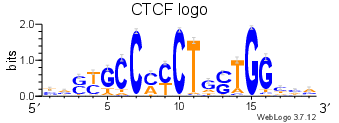

In [7]:
import tempfile, time
from IPython.display import Image
from IPython.core.display import HTML 
from Bio.Align import AlignInfo, MultipleSeqAlignment, Seq, SeqRecord
from Bio.motifs import Motif

# create a muliple sequence alignment object
msa = MultipleSeqAlignment([SeqRecord(Seq(rna.reverse_complement(ctcf.sequence.upper()) if ctcf.strand=="+" else ctcf.sequence.upper())) for ctcf,_ in t.iterator(feature_types='ctcf')])
# creat Motif with ATCG alphabet
motif = Motif("ACTG", msa.alignment)
# show consensus sequence
display(f"CTCF Consensus sequence: {motif.consensus}")

with tempfile.TemporaryDirectory(dir=rna.__RNALIB_TESTDATA__) as tmpdir:
    img_path=f"{tmpdir}/ctcf.png"
    motif.weblogo(img_path, logo_title='CTCF logo',  )
    rel_img_path = os.path.relpath(img_path, pathlib.Path(os.path.abspath(rna.__RNALIB_TESTDATA__)).parent)
    display(Image(filename=rel_img_path,unconfined=True))

You can compare to the [CTCF motif at the JASPAR website](https://jaspar.elixir.no/matrix/MA0139.1/?revcomp=1) (note the different colors though).

## Summary

This concludes our small CTCF site annotation tutorial. This tutorial demonstrated:
* How to combine *bioframe* and *rnalib* for the anotation of genes with CTCF motifs
* How to compare the performance between two different approaches for this task
* How to add custom child annotations to a transcriptome and access their sequences via *rnalib*